**Goal**

The goal of this notebook is to see how mutual information develops in an online continual learner. We will be using the MNIST dataset, broken down into different tasks.

In [ ]:
#@title Import Modules
import math
import functools

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn.functional as F
import torchvision.models as models

from collections import Counter
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms

In [ ]:
#@title Define Hyperparameters
if(torch.backends.mps.is_available()):
    device = 'mps'
elif (torch.cuda.is_available()):
    device = 'cuda'
else:
    device = 'cpu'

# Experiment parameters
pretrain      = True
tasks         = [[0,2], [5,6], [3,8]]
if pretrain:
    epochs    = 10
    numMI     = epochs + len(tasks) - 1
else:
    epochs    = 1
    numMI     = len(tasks)

# Pretraining parameters
lr            = 7e-2
milestones    = [epochs//2]
gamma         = 0.5
batch_size    = 512
momentum      = 0
weight_decay  = 0
# Online learning parameters
#lr_ol         = (1/np.arange(1, len(tasks)+1)) * 4e-4
lr_ol         = [7e-3] * len(tasks)
# Measurement variables
n_bins        = 100

In [ ]:
#@title Mutual Information Computer
def compute_mutual_information(model, class_heads, taskNum, data_loader):
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

    h_list = model(images)
    h6 = F.log_softmax(class_heads[taskNum](h_list[-1]), dim = 1)
    h_list = h_list + (h6, )

    # calculate mutual information
    layers = len(h_list)
    MI_XH = torch.zeros(layers)
    MI_YH = torch.zeros(layers)
    for layer, h in enumerate(h_list):
        # discretize images and representations
        bins = np.linspace(0, 1, n_bins+1)
        x_ = np.digitize(images.cpu(), bins)
        if layer == layers-1:
            h = torch.exp(h)
            bins = np.linspace(0, 1, n_bins+1)
        else:
            bins = np.linspace(-1, 1, n_bins+1)
        h_ = np.digitize(h.cpu().detach().numpy(), bins)
        y_ = labels.cpu()

        # calculate discrete probabilities
        p_X = Counter()
        p_Y = Counter()
        p_H = Counter()
        p_XH = Counter()
        p_YH = Counter()

        for x_i, h_i, y_i in zip(x_, h_, y_):
            def totuple(a):
                try:
                    return tuple(totuple(i) for i in a)
                except:
                    return a.item()

            unit = 1./len(images)

            p_X[totuple(x_i)]                   += unit
            p_Y[totuple(y_i)]                   += unit
            p_H[totuple(h_i)]                   += unit
            p_XH[(totuple(x_i), totuple(h_i))]  += unit
            p_YH[(totuple(y_i), totuple(h_i))]  += unit

        for xh in p_XH:
            if p_XH[xh] != 0:
                MI_XH[layer] += p_XH[xh] * math.log2(p_XH[xh] / (p_X[xh[0]] * p_H[xh[1]]))

        for yh in p_YH:
            if p_YH[yh] != 0:
                MI_YH[layer] += p_YH[yh] * math.log2(p_YH[yh] / (p_Y[yh[0]] * p_H[yh[1]]))
    return MI_XH, MI_YH

def compute_shannon_entropy(data_loader):
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
    bins = np.linspace(0, 1, n_bins+1)
    x_ = np.digitize(images.cpu(), bins)
    y_ = labels.cpu()
    p_X = Counter()
    p_Y = Counter()
    for x_i, y_i in zip(x_, y_):
        def totuple(a):
            try:
                return tuple(totuple(i) for i in a)
            except:
                return a.item()

        unit = 1./len(images)

        p_X[totuple(x_i)]                   += unit
        p_Y[totuple(y_i)]                   += unit
    X = 0
    for x in p_X:
        X -= p_X[x] * math.log2(p_X[x])
    Y = 0
    for y in p_Y:
        Y -= p_Y[y] * math.log2(p_Y[y])
    return X, Y

In [ ]:
#@title Testing
def make_test_tracker(num_tasks):
    test_tracker = {}
    for task_num in range(num_tasks):
        test_tracker[task_num] = {}
        for test_task_num in range(task_num+1):
            test_tracker[task_num][test_task_num] = []
    return test_tracker

def update_test_tracker(test_tracker, model, class_heads, task_num, test_loaders):
    # test tasks individually
    model.eval()
    for test_task_num in range(task_num + 1):
        test_loader = test_loaders[test_task_num]
        N = 0
        accuracy = 0
        for batch_idx, (images, labels) in enumerate(test_loader, start=1):
            images, labels = images.to(device), labels.to(device)

            # forward pass
            h1, h2, h3, h4, h5 = model(images)
            h6 = F.log_softmax(class_heads[test_task_num](h5), dim = 1)

            # check if predicted labels are equal to true labels
            predicted_labels = torch.argmax(h6,dim=1)
            accuracy += torch.sum((predicted_labels==labels).float()).item()
            N += images.shape[0]
        test_tracker[task_num][test_task_num].append(100. * accuracy/N)


def test_global_accuracy(model, class_heads, task_num, test_loaders):
    # TODO: complete this
    N = 0
    accuracy = 0
    for taskNum, task in enumerate(tasks):
      test_loader = get_test_loader([c for c in task])
      for batch_idx, (images, labels) in enumerate(test_loader, start=1):
        images, labels = images.to(device), labels.to(device)

        # forward pass
        h1, h2, h3, h4, h5 = model(images)
        h6 = F.log_softmax(class_heads[taskNum](h5), dim = 1)

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(h6,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]

    print(str(round(100. * accuracy/N)) + "%")
    total_accuracy = 100. * accuracy/N
    return total_accuracy, test_set_accuracy

In [ ]:
pca_components = 12

#@title Load data
#@title Data Retrieval
def process_dataset(data, task):
    conditions = []
    for c in task:
      conditions.append((data.targets == c))
    indices = functools.reduce(torch.logical_or, conditions)
    data.data, data.targets = data.data[indices], data.targets[indices]
    for i in range(len(task)):
      data.targets[data.targets == task[i]] = i
    data = TensorDataset(data.data.reshape(-1, 28*28), data.targets)
    return data

transform = transforms.ToTensor()


# Construct data
train_loaders = []
MI_loaders    = []
test_loaders  = []

for taskNum in range(len(tasks)):
  train_dataset = process_dataset(datasets.MNIST('../data', download=True, train=True, transform=transform), tasks[taskNum])
  MI_dataset    = process_dataset(datasets.MNIST('../data', download=True, train=True, transform=transform), sum(tasks[:taskNum+1], []))
  test_dataset  = process_dataset(datasets.MNIST('../data', download=True, train=False, transform=transform), tasks[taskNum])

  # use PCA to reduce to lower dimensions
  pca = PCA(n_components=pca_components)
  pca.fit(train_dataset.tensors[0])
  train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])
  MI_dataset.tensors    = (torch.from_numpy(pca.transform(MI_dataset.tensors[0])).float(), MI_dataset.tensors[1])
  test_dataset.tensors  = (torch.from_numpy(pca.transform(test_dataset.tensors[0])).float(), test_dataset.tensors[1])

  # dataset loaders
  if pretrain and taskNum == 0:
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
  else:
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle=True, drop_last=True)

  MI_loader_temp = torch.utils.data.DataLoader(
      MI_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

  MI_loader = torch.utils.data.DataLoader(
      MI_dataset, batch_size=len(MI_loader_temp.dataset), shuffle=False, drop_last=False)

  test_loader = torch.utils.data.DataLoader(
      test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

  test_loader_full = torch.utils.data.DataLoader(
      test_dataset, batch_size = len(test_loader.dataset), shuffle=False, drop_last=False)
  # save loaders
  train_loaders.append(train_loader)
  MI_loaders.append(MI_loader)
  test_loaders.append(test_loader_full)

In [ ]:
#@title Define Model
class Model(nn.Module):
    def __init__(self):
      super(Model, self).__init__()
      self.fc1 = nn.Linear(pca_components, 10)
      self.fc2 = nn.Linear(10, 7)
      self.fc3 = nn.Linear(7, 5)
      self.fc4 = nn.Linear(5, 4)
      self.fc5 = nn.Linear(4, 3)
      self.is_online = True

    def forward(self, x):
      h1 = torch.tanh(self.fc1(x))
      h2 = torch.tanh(self.fc2(h1))
      h3 = torch.tanh(self.fc3(h2))
      h4 = torch.tanh(self.fc4(h3))
      h5 = torch.tanh(self.fc5(h4))
      return h1, h2, h3, h4, h5

In [ ]:
# Model setup
model       = Model().to(device)
class_heads = {i : nn.Linear(3, len(tasks[0])).to(device) for i in range(len(tasks))}
loss_function = nn.NLLLoss()

#@title Pre-Train Model
train_accuracy        = []
global_test_accuracy  = []
test_tracker          = make_test_tracker(len(tasks))
firstOnlineTask       = 0

# Mutual information metrics
layers              = len(list(model.children())) + 1
MI_XH               = torch.zeros(len(tasks), epochs, layers)
MI_YH               = torch.zeros(len(tasks), epochs, layers)
if pretrain:
    print("Pre-training on task number 1")
    firstOnlineTask = 1
    parameters = list(model.parameters()) + list(class_heads[0].parameters())
    optimizer       = optim.SGD(parameters,
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)

    scheduler       = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    for epoch in range(epochs):
        print("   Epoch:", epoch+1, "/", epochs)
        # train phase
        print("       Training")
        model.train()
        accuracy = 0
        N = 0

        # iterate over train data
        for batch_idx, (images, labels) in enumerate(train_loaders[0], start=1):
            images, labels = images.to(device), labels.to(device)

            # forward pass
            h1, h2, h3, h4, h5 = model(images)
            h6 = F.log_softmax(class_heads[0](h5), dim = 1)
            loss = loss_function(h6, labels)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # check if predicted labels are equal to true labels
            predicted_labels = torch.argmax(h6,dim=1)
            accuracy += torch.sum((predicted_labels==labels).float()).item()
            N += images.shape[0]
        train_accuracy.append(100. * accuracy/N)
        scheduler.step()

        print("       Evaluating tests")
        update_test_tracker(test_tracker, model, class_heads, 0, test_loaders)
        # calculate mutual information
        print("       Computing mutual information")
        MI_XH[0, epoch], MI_YH[0, epoch] = compute_mutual_information(
            model, class_heads, 0, MI_loaders[0])
    firstOnlineTask = 1

Pre-training on task number 1
   Epoch: 1 / 10
       Training
       Evaluating tests
       Computing mutual information
   Epoch: 2 / 10
       Training
       Evaluating tests
       Computing mutual information
   Epoch: 3 / 10
       Training
       Evaluating tests
       Computing mutual information
   Epoch: 4 / 10
       Training
       Evaluating tests
       Computing mutual information
   Epoch: 5 / 10
       Training
       Evaluating tests
       Computing mutual information
   Epoch: 6 / 10
       Training
       Evaluating tests
       Computing mutual information
   Epoch: 7 / 10
       Training
       Evaluating tests
       Computing mutual information
   Epoch: 8 / 10
       Training
       Evaluating tests
       Computing mutual information
   Epoch: 9 / 10
       Training
       Evaluating tests
       Computing mutual information
   Epoch: 10 / 10
       Training
       Evaluating tests
       Computing mutual information


In [ ]:
#@title Online Learn
for task_num in range(firstOnlineTask, len(tasks)):
    print("Task Number:", task_num+1, "/", len(tasks))
    parameters = list(model.parameters()) + list(class_heads[task_num].parameters())
    optimizer = optim.SGD(parameters,
                      lr=lr_ol[task_num],
                      momentum=momentum,
                      weight_decay=weight_decay)

    # train phase
    print("   Training")
    model.train()
    accuracy = 0
    N = 0
    num_samples = len(train_loaders[task_num].dataset)
    interval = num_samples // epochs
    MI_sample = 0

    # iterate over train data
    for training_sample, (images, labels) in enumerate(train_loaders[task_num], start=1):
        images, labels = images.to(device), labels.to(device)

        # forward pass
        h1, h2, h3, h4, h5 = model(images)
        h6 = F.log_softmax(class_heads[task_num](h5), dim = 1)
        loss = loss_function(h6, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(h6,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]
        if N % interval == 0 and MI_sample < epochs - 1:
            print(f"      Completed {round(((N)/num_samples)*100)}% of online training!", end="")
            print("Computing MI... ", end="")
            MI_XH[task_num, MI_sample], MI_YH[task_num, MI_sample] = compute_mutual_information(
                model, class_heads, 0, MI_loaders[0])
            MI_sample += 1
            print("done! ", end="")
            print("Updating test tracker... ", end="")
            update_test_tracker(test_tracker, model, class_heads, task_num, test_loaders)
            print("done!")
    print(f"      Completed 100% of online training!", end="")
    print("Computing MI... ", end="")
    MI_XH[task_num, MI_sample], MI_YH[task_num, MI_sample] = compute_mutual_information(
        model, class_heads, 0, MI_loaders[0]
    )
    print("done! ", end="")
    print("Updating test tracker... ", end="")
    update_test_tracker(test_tracker, model, class_heads, task_num, test_loaders)
    print("done!")
    train_accuracy.append(100. * accuracy/N)

    # test phase
    print("       Evaluating tests")
    update_test_tracker(test_tracker, model, class_heads, task_num, test_loaders)

Task Number: 2 / 3
   Training
      Completed 10% of online training
         Computing MI
         Updating test tracker
      Completed 20% of online training
         Computing MI
         Updating test tracker
      Completed 30% of online training
         Computing MI
         Updating test tracker
      Completed 40% of online training
         Computing MI
         Updating test tracker
      Completed 50% of online training
         Computing MI
         Updating test tracker
      Completed 60% of online training
         Computing MI
         Updating test tracker
      Completed 70% of online training
         Computing MI
         Updating test tracker
      Completed 80% of online training
         Computing MI
         Updating test tracker
      Completed 90% of online training
         Computing MI
         Updating test tracker
      Completed 100% of online training
         Computing MI
         Updating test tracker
       Evaluating tests
Task Number: 3 / 3
   Tr

In [ ]:
#@title Compute Forgetting Metrics
ave_accuracy        = []
ave_inc_accuracy    = []
forgetting_measure  = []
backward_transfer   = []

# Compute average accuracy
for task_num in range(len(tasks)):
    for epoch in range(epochs):
        ave_accuracy.append(0)
        for test_task_num in range(task_num + 1):
            ave_accuracy[-1] += test_tracker[task_num][test_task_num][epoch]
        ave_accuracy[-1] = ave_accuracy[-1] / (task_num+1)

# Compute backward transfer
for task_num in range(1, len(tasks)):
    for epoch in range(epochs):
        backward_transfer.append(0)
        for test_task_num in range(task_num):
            backward_transfer[-1] += test_tracker[task_num][test_task_num][epoch]
            backward_transfer[-1] -= test_tracker[test_task_num][test_task_num][-1]
        backward_transfer[-1] /= task_num
backward_transfer = [0] * epochs + backward_transfer
"""
# Compute average incremental accuracy
for taskNum in range(len(tasks)):
    ave_inc_accuracy.append(0)
    for testTaskNum in range(taskNum+1):
      ave_inc_accuracy[-1] += ave_accuracy[testTaskNum]
    ave_inc_accuracy[-1] = ave_inc_accuracy[-1] / (taskNum+1)

# Compute forgetting measure
for taskNum in range(1,len(tasks)):
    forgetting_measure.append(0)
    for testTaskNum in range(taskNum):
      f = -math.inf
      for i in range(testTaskNum, taskNum):
        if test_set_accuracy[(i, testTaskNum)] > f:
          f = test_set_accuracy[(i, testTaskNum)]
      forgetting_measure[-1] += f - test_set_accuracy[(taskNum, testTaskNum)]
    forgetting_measure[-1] = forgetting_measure[-1] / taskNum
"""

'\n# Compute average incremental accuracy\nfor taskNum in range(len(tasks)):\n    ave_inc_accuracy.append(0)\n    for testTaskNum in range(taskNum+1):\n      ave_inc_accuracy[-1] += ave_accuracy[testTaskNum]\n    ave_inc_accuracy[-1] = ave_inc_accuracy[-1] / (taskNum+1)\n\n# Compute forgetting measure\nfor taskNum in range(1,len(tasks)):\n    forgetting_measure.append(0)\n    for testTaskNum in range(taskNum):\n      f = -math.inf\n      for i in range(testTaskNum, taskNum):\n        if test_set_accuracy[(i, testTaskNum)] > f:\n          f = test_set_accuracy[(i, testTaskNum)]\n      forgetting_measure[-1] += f - test_set_accuracy[(taskNum, testTaskNum)]\n    forgetting_measure[-1] = forgetting_measure[-1] / taskNum\n'

In [ ]:
#@title Compute Mutual Information Aggregates
MI_XH_data = torch.flatten(MI_XH, start_dim=0, end_dim=1)
MI_YH_data = torch.flatten(MI_YH, start_dim=0, end_dim=1)
SE_X, SE_Y = compute_shannon_entropy(MI_loaders[0])
MI_XH_perc = 100. * (MI_XH_data / SE_X)
MI_YH_perc = 100. * (MI_YH_data / SE_Y)
ave_MI_XH_perc = torch.mean(MI_XH_perc, dim=1)
ave_MI_YH_perc = torch.mean(MI_YH_perc, dim=1)

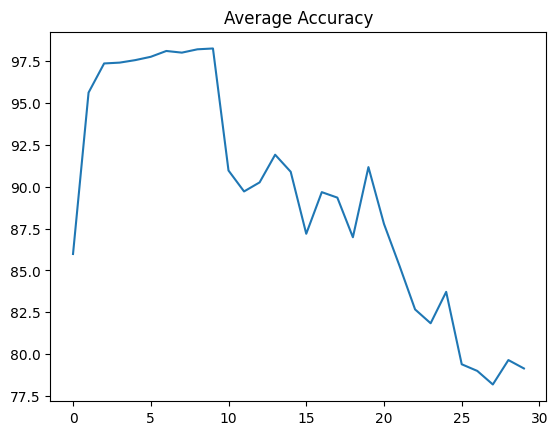

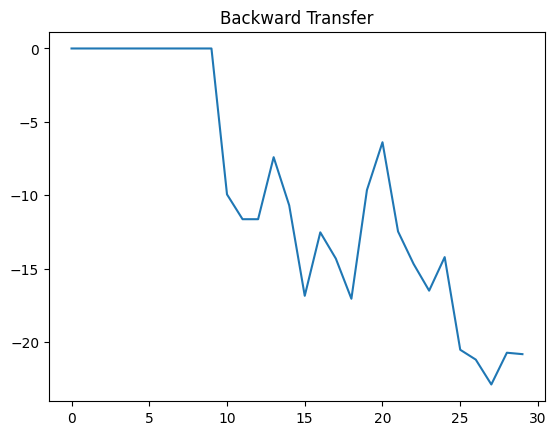

<Figure size 640x480 with 0 Axes>

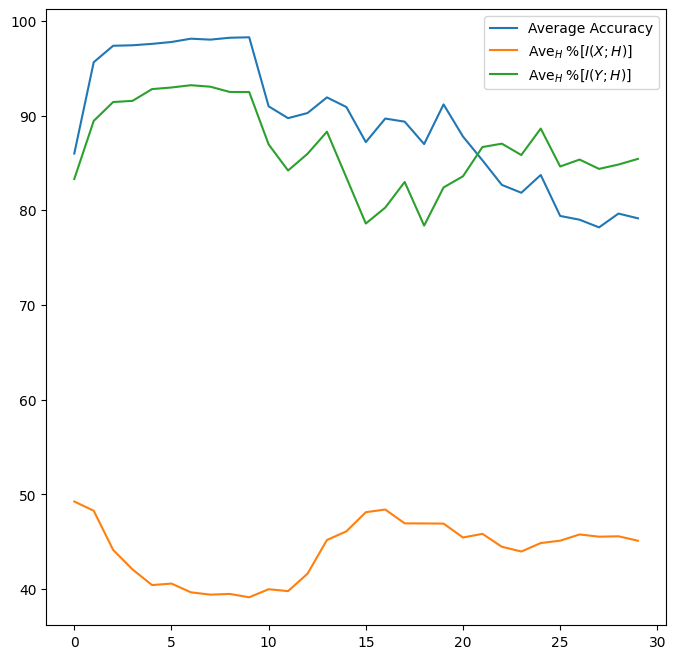

<Figure size 640x480 with 0 Axes>

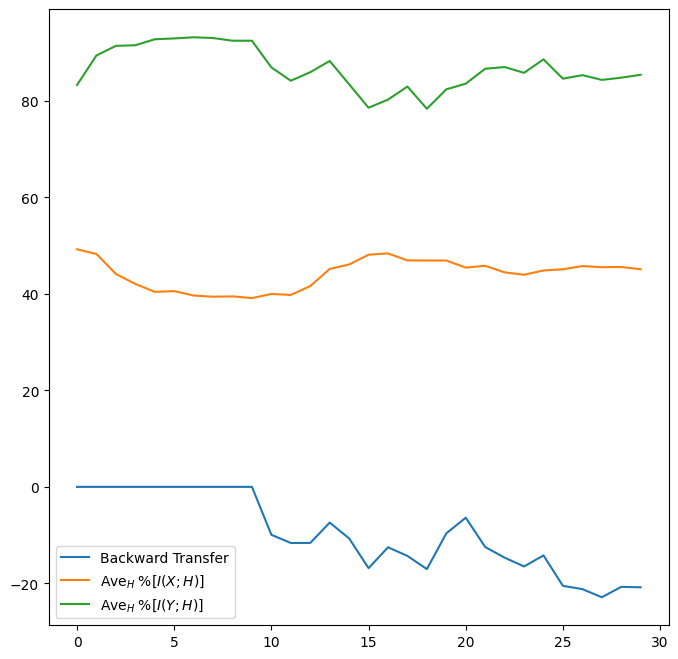

In [ ]:
#@title Make Plots
plt.figure()
plt.title("Average Accuracy")
plt.plot(ave_accuracy)

plt.figure()
plt.title("Backward Transfer")
plt.plot(backward_transfer)

plt.figure()
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ave_accuracy, label="Average Accuracy")
ax.plot(ave_MI_XH_perc, label="$\mathrm{Ave}_H \; \%[I(X;H)]$")
ax.plot(ave_MI_YH_perc, label="$\mathrm{Ave}_H \; \%[I(Y;H)]$")
plt.legend()

plt.figure()
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(backward_transfer, label="Backward Transfer")
ax.plot(ave_MI_XH_perc, label="$\mathrm{Ave}_H \; \%[I(X;H)]$")
ax.plot(ave_MI_YH_perc, label="$\mathrm{Ave}_H \; \%[I(Y;H)]$")
plt.legend()

In [ ]:
#@title Animation Function
import matplotlib.lines as mlines
def animate_all_MI(XH_data, YH_data, task_epochs, title_str):
    plt.figure()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlabel('$\hat{I}(X,H)$')
    ax.set_xlim([0, XH_data.max() + 0.5])
    ax.set_ylim([0, YH_data.max() + 0.1])
    ax.set_ylabel('$\hat{I}(Y,H)$')
    title = ax.set_title(title_str)
    # Construct epoch colour map (for dots)
    tasks = len(task_epochs)
    epochs = XH_data.size()[1]
    cmap_dots = plt.get_cmap('gnuplot', tasks)
    dot_colors = []
    for task in range(len(task_epochs)):
        dot_colors += [cmap_dots(task)] * task_epochs[task]

    # Construct layer colour map (for lines)
    layers = XH_data.size()[2]
    cmap_lines = plt.get_cmap('tab10', layers)
    line_colors = [cmap_lines(i) for i in np.arange(0, layers)]

    # initiate plot
    plots = {'layer': [], 'epoch': []}
    for layer in range(layers):
        x = XH_data[0, 0, layer]
        y = YH_data[0, 0, layer]
        plots["layer"].append(ax.plot(x, y, '-', color=line_colors[layer], label="Layer " + str(layer+1)))
        plots["epoch"].append(ax.scatter(x, y, c=dot_colors[0]))

    layer_plots_temp = []
    for layer in range(layers):
        layer_plots_temp.append(plots["layer"][layer][0])
    plots["layer"] = layer_plots_temp


    layer_legend = ax.legend(handles=plots["layer"], loc="upper right")
    ax.add_artist(layer_legend)
    task_handles = []
    for task in range(len(task_epochs)):
        legend_dot = mlines.Line2D([], [], color=cmap_dots(task), marker=".",
                                   markersize=15, label="Task " + str(task+1))
        task_handles.append(legend_dot)
    second_legend = ax.legend(handles=task_handles, loc="lower right")

    XH_data = torch.flatten(XH_data, start_dim=0, end_dim=1)
    YH_data = torch.flatten(YH_data, start_dim=0, end_dim=1)

    def update(frame):
        # update axis data
        for layer in range(layers):
            x = XH_data[:frame,layer]
            y = YH_data[:frame,layer]
            plots["layer"][layer].set_xdata(x)
            plots["layer"][layer].set_ydata(y)
            data = np.stack([x,y]).T
            plots["epoch"][layer].set_offsets(data)
            plots["epoch"][layer].set_color(dot_colors[:frame])
        # update lines
    fig.tight_layout()
    ani = animation.FuncAnimation(fig=fig, func=update, frames=XH_data.size()[0] + 10, interval=300)
    return ani

<ipython-input-71-6643b5050c0c>:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plots["epoch"].append(ax.scatter(x, y, c=dot_colors[0]))


<Figure size 640x480 with 0 Axes>

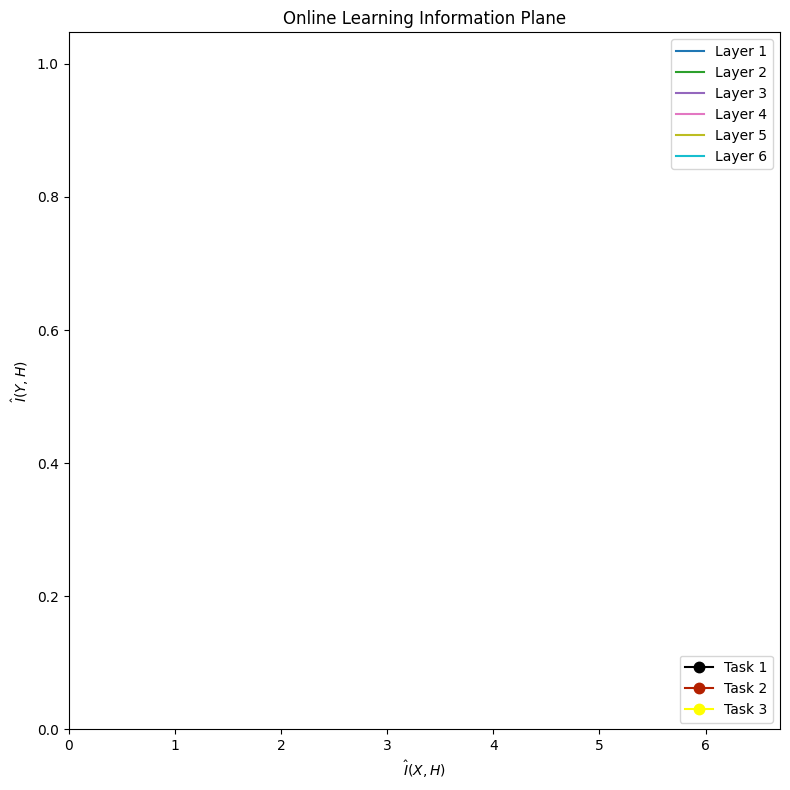

In [ ]:
#@title Animation
task_epochs = [10] + [10] * (len(tasks)-1)
ani = animate_all_MI(MI_XH, MI_YH, task_epochs, "Online Learning Information Plane")
ani.save("online_all_tasks.gif", writer="pillow")